In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 최대 단어 개수를 10,000으로 제한하고 훈련 데이터와 테스트 데이터를 받아온다.
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

17473536/17464789 [==============================] - 0s 0us/step
리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


훈련 데이터와 이에 대한 레이블이 각각 X_train, y_train에 테스트 데이터와 이에 대한 레이블이 각각 X_test, y_test에 저장되었습니다. IMDB 리뷰 데이터는 이미 정수 인코딩이 된 상태므로 남은 전처리는 패딩뿐입니다. 

리뷰의 최대 길이와 평균 길이를 확인해보면 리뷰의 최대 길이는 2,494이며 리뷰의 평균 길이는 약 238로 확인된다.

평균 길이보다는 조금 크게 데이터를 패딩한다.

In [2]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
# 훈련용 리뷰와 테스트용 리뷰의 길이 둘 다 500

# 바다나우 어텐션(Bahdanau Attention)

어텐션 스코어 함수란 주어진 query와 모든 key에 대해서 유사도를 측정하는 함수를 말한다. 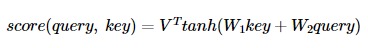

RNN의 마지막 은닉 상태는 예측을 위해 사용되는데, 몇 가지 유용한 정보들을 손실한 상태이다. 따라서 어텐션 메커니즘을 사용하면사 RNN.이 time step을 지나며 손실했던 정보들을 다시 참고하고자 함.

In [3]:
import tensorflow as tf

In [4]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# 양방향 LSTM + 어텐션 메커니즘(BiLSTM with Attention Mechanism)

In [5]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [6]:
# 모델 설계
# 입력층과 임베딩층을 설계
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input) # 10,000개의 단어들을 128차원의 벡터로 임베딩

In [7]:
# 양방향 LSTM 설계
# 양방향 LSTM 두 층을 사용하기 위해 첫번째 층 옵션 return_seq = True 설정
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

In [8]:
# 두번째 층
# 상태를 리턴받아야 하므로 return_state = True로 설정
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [9]:
# 각 상태의 크기(shape)를 출력
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 500, 128) (None, 64) (None, 64) (None, 64) (None, 64)


순방향 LSTM의 은닉 상태와 셀상태를 forward_h, forward_c에 저장하고, 역방향 LSTM의 은닉 상태와 셀 상태를 backward_h, backward_c에 저장합니다.

각 은닉 상태나 셀 상태의 경우에는 128차원을 가지는데, lstm의 경우에는 (500 × 128)의 크기를 가집니다. foward 방향과 backward 방향이 연결된 hidden state벡터가 모든 시점에 대해서 존재함을 의미합니다.

**양방향 LSTM을 사용할 경우에는 순방향 LSTM과 역방향 LSTM 각각 은닉 상태와 셀 상태를 가지므로, 양방향 LSTM의 은닉 상태와 셀 상태를 사용하려면 두 방향의 LSTM의 상태들을 연결(concatenate)해주면 됩니다.**



In [10]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

어텐션 메커니즘에서는 은닉 상태를 사용합니다. 이를 입력으로 컨텍스트 벡터(context vector)를 얻습니다.

In [11]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h) # 은닉 상태 넘겨줌

컨텍스트 벡터를 밀집층(dense layer)에 통과시키고, 이진 분류이므로 최종 출력층에 1개의 뉴런을 배치하고, 활성화 함수로 시그모이드 함수를 사용합니다.

In [12]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

옵티마이저로 아담 옵티마이저 사용하고, 모델을 컴파일합니다.

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

시그모이드 함수를 사용하므로 손실 함수로 binary_crossentropy를 사용하였습니다. 이제 모델을 훈련하겠습니다.

In [14]:
history = model.fit(X_train, y_train, epochs = 3, batch_size = 256, validation_data=(X_test, y_test), verbose=1)

Epoch 1/3
98/98 [==============================] - 701s 7s/step - loss: 0.4722 - accuracy: 0.7698 - val_loss: 0.2908 - val_accuracy: 0.8798
Epoch 2/3
98/98 [==============================] - 669s 7s/step - loss: 0.2387 - accuracy: 0.9143 - val_loss: 0.2929 - val_accuracy: 0.8815
Epoch 3/3
98/98 [==============================] - 644s 7s/step - loss: 0.1844 - accuracy: 0.9355 - val_loss: 0.3082 - val_accuracy: 0.8780


검증 데이터로 테스트 데이터를 사용하여 에포크가 끝날 때마다 테스트 데이터에 대한 정확도를 출력하도록 하였습니다.

In [15]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 456s 584ms/step - loss: 0.3082 - accuracy: 0.8780

 테스트 정확도: 0.8780
